In [1]:
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt

from torch import optim, nn
from modules.dataset import *
from modules.network import *
from modules.embeddings import *
from torch import save, device, cuda
from torch.utils.data import DataLoader

In [2]:
device = device("cuda") if cuda.is_available() else device("cpu")
print('Selected device:', device)

Selected device: cpu


In [3]:
# Set local paths
images_path = "./images"
res_path = "./data/losses"

# Dataset

## Loading and preprocessing

In [4]:
#%%Loading the dataset 

min_len = 10
dataset = Mobydick('./data/mobydick.txt', min_len = min_len)

with open('./data/clean_text', 'wb') as f:
    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
    
len(dataset)

466

In [5]:
# Given a min_len>2, it is not necessary to delete the chapters titles
print(dataset[0])

['some', 'years', 'ago', 'never', 'mind', 'how', 'long', 'precisely', 'having', 'little', 'or', 'no', 'money', 'in', 'my', 'purse', ',', 'and', 'nothing', 'particular', 'to', 'interest', 'me', 'on', 'shore', ',', 'i', 'thought', 'i', 'would', 'sail', 'about', 'a', 'little', 'and', 'see', 'the', 'watery', 'part', 'of', 'the', 'world', '.']


Mean sentence length: 30.446351931330472
Max sentence length: 127
Min sentence length: 10


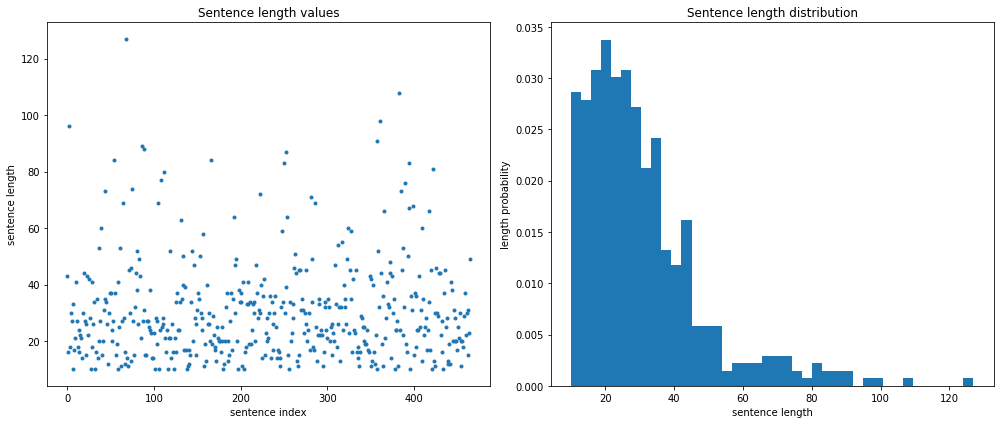

In [6]:
# Dataset visualization
lengths = [ len(sentence)  for sentence in dataset ]
fig, axs = plt.subplots(1, 2, figsize=(14,6))
axs.ravel()
axs[0].set_title('Sentence length values')
axs[0].set_xlabel('sentence index')
axs[0].set_ylabel('sentence length')
_ = axs[0].plot(lengths, '.')
axs[1].set_title('Sentence length distribution')
axs[1].set_xlabel('sentence length')
axs[1].set_ylabel('length probability')
_ = axs[1].hist(lengths, bins=40, density=True)

print('Mean sentence length:', np.mean(lengths))
print('Max sentence length:', np.max(lengths))
print('Min sentence length:', np.min(lengths))

plt.tight_layout()
plt.savefig(images_path+f'/md_{min_len}.png')
plt.show()

In [7]:
print(len(dataset.words))

14188


## Word embeddings

In [8]:
# Define the embedding dimension
embedding_dim = 50

# Copy dataset words
words = set(dataset.words.copy())

In [9]:
# Load embeddings
with open('./data/embeddings', 'rb') as f:
    embeddings = pickle.load(f)

# Get list of words
words = [*embeddings.keys()]
# Get vectors as float tensor
vectors = torch.tensor([*embeddings.values()], dtype=torch.float)

In [10]:
crop_len = 10

# Define transformation 
dataset.transform = transforms.Compose([
    RandomCrop(crop_len),
    WordToVector(words),
    ToTensor()
])

In [11]:
# Defined the transform, this call returns the word index (after random cropping)
dataset[0].shape

torch.Size([10])

# LSTM

In [12]:
##Parameters

params = {
        # network
        'hidden_units' : 2**8, # symmetric layers
        'layers_num' : 2,
        'dropout_prob' : 0.4,

        # training
        'batch_size' : 100,
        'num_epochs' : 600,

        # optimizer
        'lr' : 1e-3,
        'wd' : 1e-4,
    
        # dataset
        'crop_len' : crop_len,
        'min_len' : min_len
        }

# save
out_dir = f'LSTM_{crop_len}_{min_len}'+'_{}_{}'.format(params['lr'],params['wd'])

In [13]:
# Split initial dataset in train dataset and test dataset
train_dataset, test_dataset = split_train_test(dataset, 0.9)
# Make train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
# Make test dataloader
test_dataloader = DataLoader(test_dataset, shuffle=False)

In [14]:
#TODO: hyperparameter optimization, this part must be included in the GridSearch iteration

#%% Initialize network
net = Network(vocab_size = vectors.shape[0],
              embedding_dim = embedding_dim,
              hidden_units = params['hidden_units'],
              layers_num = params['layers_num'],
              hidden_type = 'LSTM',
              trained_embeddings = vectors,
              dropout_prob = params['dropout_prob']
             )

# Define optimizer
optimizer = optim.Adam(net.parameters(), lr=params['lr'], weight_decay=params['wd'])
# Define loss function
loss_fn = nn.MSELoss()
# loss_fn = nn.NLLLoss()

net.to(device)

Network(
  (rnn): LSTM(50, 256, num_layers=2, batch_first=True, dropout=0.4)
  (out): Linear(in_features=256, out_features=50, bias=True)
  (embed): Embedding(2998, 50)
)

In [15]:
%%time

#%% Train network

# Define losses containers
train_loss_epochs = []
val_loss_epochs = []

for epoch in range(params['num_epochs']):
    print('\n\n EPOCH %d/%d' % (epoch + 1, params['num_epochs']))
    
    # Set training mode
    net.train()
    # Define losses container for one epoch
    train_loss_log = []
    
    # Iterate batches
    for batch_sample in train_dataloader:
        # Extract batch
        batch = batch_sample.long().to(device)
        # Update network
        batch_loss = net.train_batch(batch, loss_fn, optimizer)
        train_loss_log.append(batch_loss)
        # print('\t Training loss (single batch):', batch_loss)
        
    print('\t Training loss (epoch - mean): ', np.mean(train_loss_log) )
    train_loss_epochs.append(np.mean(train_loss_log))
    
    # Set evaluation mode
    net.eval()
    val_loss_log = []
    with torch.no_grad():
        for batch_sample in test_dataloader:
            batch = batch_sample.long().to(device)
            val_loss = net.test_batch(batch, loss_fn)
            val_loss_log.append(val_loss)
            
        print('\t Validation loss (epoch - mean):', np.mean(val_loss_log))
        val_loss_epochs.append(np.mean(val_loss_log))
        
    # Early stopping
    # if epoch>200 and abs(val_loss_epochs[-1] - val_loss_epochs[-200]) < 1e-10:
    #    break
    
losses = { 'train': train_loss_epochs, 'val':  val_loss_epochs, 'params' : params }

# Save losses dictionary
with open(res_path + "/" + out_dir, 'wb') as f:
    pickle.dump(losses, f, pickle.HIGHEST_PROTOCOL)
    
# Save model 
torch.save(net.state_dict(), res_path + "/state_" + out_dir + '.pth')



 EPOCH 1/600
	 Training loss (epoch - mean):  0.43082945346832274
	 Validation loss (epoch - mean): 0.328190970294019


 EPOCH 2/600
	 Training loss (epoch - mean):  0.27635726034641267
	 Validation loss (epoch - mean): 0.24536918317700954


 EPOCH 3/600
	 Training loss (epoch - mean):  0.23848602473735808
	 Validation loss (epoch - mean): 0.2408168594887916


 EPOCH 4/600
	 Training loss (epoch - mean):  0.2525045216083527
	 Validation loss (epoch - mean): 0.2194984426048208


 EPOCH 5/600
	 Training loss (epoch - mean):  0.22394436001777648
	 Validation loss (epoch - mean): 0.24011506314607375


 EPOCH 6/600
	 Training loss (epoch - mean):  0.2419037103652954
	 Validation loss (epoch - mean): 0.27364554795178964


 EPOCH 7/600
	 Training loss (epoch - mean):  0.21676036715507507
	 Validation loss (epoch - mean): 0.20888136707721872


 EPOCH 8/600
	 Training loss (epoch - mean):  0.22861344814300538
	 Validation loss (epoch - mean): 0.25077565751494246


 EPOCH 9/600
	 Training loss

	 Training loss (epoch - mean):  0.12379821836948394
	 Validation loss (epoch - mean): 0.1337519036804108


 EPOCH 69/600
	 Training loss (epoch - mean):  0.11380377560853958
	 Validation loss (epoch - mean): 0.1248388933265542


 EPOCH 70/600
	 Training loss (epoch - mean):  0.11201029866933823
	 Validation loss (epoch - mean): 0.08699799000107228


 EPOCH 71/600
	 Training loss (epoch - mean):  0.10257710963487625
	 Validation loss (epoch - mean): 0.1249713488913914


 EPOCH 72/600
	 Training loss (epoch - mean):  0.12052165865898132
	 Validation loss (epoch - mean): 0.12398099561439867


 EPOCH 73/600
	 Training loss (epoch - mean):  0.11493197530508041
	 Validation loss (epoch - mean): 0.12939341816100033


 EPOCH 74/600
	 Training loss (epoch - mean):  0.12222801595926285
	 Validation loss (epoch - mean): 0.12808994867620951


 EPOCH 75/600
	 Training loss (epoch - mean):  0.11685421466827392
	 Validation loss (epoch - mean): 0.12781729734443287


 EPOCH 76/600
	 Training loss (ep

	 Training loss (epoch - mean):  0.06977131962776184
	 Validation loss (epoch - mean): 0.06100860659151952


 EPOCH 136/600
	 Training loss (epoch - mean):  0.06953867748379708
	 Validation loss (epoch - mean): 0.06687127806226466


 EPOCH 137/600
	 Training loss (epoch - mean):  0.0681984044611454
	 Validation loss (epoch - mean): 0.0582632297858041


 EPOCH 138/600
	 Training loss (epoch - mean):  0.06784138157963752
	 Validation loss (epoch - mean): 0.06297132614108318


 EPOCH 139/600
	 Training loss (epoch - mean):  0.07014127299189568
	 Validation loss (epoch - mean): 0.05738603081083559


 EPOCH 140/600
	 Training loss (epoch - mean):  0.06930553540587425
	 Validation loss (epoch - mean): 0.05524101045894179


 EPOCH 141/600
	 Training loss (epoch - mean):  0.06755430996417999
	 Validation loss (epoch - mean): 0.06454697489352064


 EPOCH 142/600
	 Training loss (epoch - mean):  0.06645641922950744
	 Validation loss (epoch - mean): 0.07302475942080801


 EPOCH 143/600
	 Training

	 Training loss (epoch - mean):  0.0469595305621624
	 Validation loss (epoch - mean): 0.04362698708799608


 EPOCH 202/600
	 Training loss (epoch - mean):  0.0425373800098896
	 Validation loss (epoch - mean): 0.03342108403709024


 EPOCH 203/600
	 Training loss (epoch - mean):  0.04138937592506409
	 Validation loss (epoch - mean): 0.057351330649404925


 EPOCH 204/600
	 Training loss (epoch - mean):  0.0464983195066452
	 Validation loss (epoch - mean): 0.04197673919670125


 EPOCH 205/600
	 Training loss (epoch - mean):  0.043252840638160706
	 Validation loss (epoch - mean): 0.03852476170435151


 EPOCH 206/600
	 Training loss (epoch - mean):  0.04453137889504433
	 Validation loss (epoch - mean): 0.037994124532796124


 EPOCH 207/600
	 Training loss (epoch - mean):  0.03988181613385677
	 Validation loss (epoch - mean): 0.03824084932777159


 EPOCH 208/600
	 Training loss (epoch - mean):  0.04418380185961723
	 Validation loss (epoch - mean): 0.039332468321477555


 EPOCH 209/600
	 Train

	 Training loss (epoch - mean):  0.029136351868510248
	 Validation loss (epoch - mean): 0.03459041261552595


 EPOCH 268/600
	 Training loss (epoch - mean):  0.029567525535821915
	 Validation loss (epoch - mean): 0.02898526001236144


 EPOCH 269/600
	 Training loss (epoch - mean):  0.028865362331271172
	 Validation loss (epoch - mean): 0.028604947005775063


 EPOCH 270/600
	 Training loss (epoch - mean):  0.028272806107997893
	 Validation loss (epoch - mean): 0.02594952939073258


 EPOCH 271/600
	 Training loss (epoch - mean):  0.027908480912446975
	 Validation loss (epoch - mean): 0.03387682585471726


 EPOCH 272/600
	 Training loss (epoch - mean):  0.02894861102104187
	 Validation loss (epoch - mean): 0.03189317517458124


 EPOCH 273/600
	 Training loss (epoch - mean):  0.02603638581931591
	 Validation loss (epoch - mean): 0.025581091298087638


 EPOCH 274/600
	 Training loss (epoch - mean):  0.030722136795520782
	 Validation loss (epoch - mean): 0.030291425516244343


 EPOCH 275/600

	 Training loss (epoch - mean):  0.01976388394832611
	 Validation loss (epoch - mean): 0.020582151525849576


 EPOCH 334/600
	 Training loss (epoch - mean):  0.019620497524738312
	 Validation loss (epoch - mean): 0.02074728407364517


 EPOCH 335/600
	 Training loss (epoch - mean):  0.021578021720051764
	 Validation loss (epoch - mean): 0.024576918521098435


 EPOCH 336/600
	 Training loss (epoch - mean):  0.01885843724012375
	 Validation loss (epoch - mean): 0.024170859203800223


 EPOCH 337/600
	 Training loss (epoch - mean):  0.019880450144410134
	 Validation loss (epoch - mean): 0.023219088725919063


 EPOCH 338/600
	 Training loss (epoch - mean):  0.02461107149720192
	 Validation loss (epoch - mean): 0.01836825177467309


 EPOCH 339/600
	 Training loss (epoch - mean):  0.01812467463314533
	 Validation loss (epoch - mean): 0.030874980737435373


 EPOCH 340/600
	 Training loss (epoch - mean):  0.0181330144405365
	 Validation loss (epoch - mean): 0.02111172117169035


 EPOCH 341/600
	

	 Training loss (epoch - mean):  0.014327146857976914
	 Validation loss (epoch - mean): 0.024410230915701176


 EPOCH 400/600
	 Training loss (epoch - mean):  0.015061381459236144
	 Validation loss (epoch - mean): 0.02273890948631464


 EPOCH 401/600
	 Training loss (epoch - mean):  0.012203044816851616
	 Validation loss (epoch - mean): 0.018066215230414566


 EPOCH 402/600
	 Training loss (epoch - mean):  0.014053799025714398
	 Validation loss (epoch - mean): 0.017512261650173312


 EPOCH 403/600
	 Training loss (epoch - mean):  0.015276487916707993
	 Validation loss (epoch - mean): 0.018546306837147024


 EPOCH 404/600
	 Training loss (epoch - mean):  0.011119433492422105
	 Validation loss (epoch - mean): 0.018622796851249925


 EPOCH 405/600
	 Training loss (epoch - mean):  0.011375354044139386
	 Validation loss (epoch - mean): 0.0208501175768609


 EPOCH 406/600
	 Training loss (epoch - mean):  0.012504244968295098
	 Validation loss (epoch - mean): 0.024663137693696238


 EPOCH 407

	 Training loss (epoch - mean):  0.009843136556446553
	 Validation loss (epoch - mean): 0.01707199952835118


 EPOCH 466/600
	 Training loss (epoch - mean):  0.01055689286440611
	 Validation loss (epoch - mean): 0.01893450775489637


 EPOCH 467/600
	 Training loss (epoch - mean):  0.01135057620704174
	 Validation loss (epoch - mean): 0.01648717615032009


 EPOCH 468/600
	 Training loss (epoch - mean):  0.010150130651891232
	 Validation loss (epoch - mean): 0.015362844178564549


 EPOCH 469/600
	 Training loss (epoch - mean):  0.008944113738834858
	 Validation loss (epoch - mean): 0.015923088492932135


 EPOCH 470/600
	 Training loss (epoch - mean):  0.009991350211203098
	 Validation loss (epoch - mean): 0.017805584686550687


 EPOCH 471/600
	 Training loss (epoch - mean):  0.008680804632604122
	 Validation loss (epoch - mean): 0.01221845370309893


 EPOCH 472/600
	 Training loss (epoch - mean):  0.009885655343532562
	 Validation loss (epoch - mean): 0.015832288456372322


 EPOCH 473/60

	 Training loss (epoch - mean):  0.007519609667360783
	 Validation loss (epoch - mean): 0.013675999498716803


 EPOCH 532/600
	 Training loss (epoch - mean):  0.007622739393264055
	 Validation loss (epoch - mean): 0.014765671293370109


 EPOCH 533/600
	 Training loss (epoch - mean):  0.0075229317881166935
	 Validation loss (epoch - mean): 0.013681217991843563


 EPOCH 534/600
	 Training loss (epoch - mean):  0.008331123925745487
	 Validation loss (epoch - mean): 0.010924067641447417


 EPOCH 535/600
	 Training loss (epoch - mean):  0.0076410527341067794
	 Validation loss (epoch - mean): 0.011119680524372713


 EPOCH 536/600
	 Training loss (epoch - mean):  0.006038494221866131
	 Validation loss (epoch - mean): 0.011935996176536255


 EPOCH 537/600
	 Training loss (epoch - mean):  0.007305328082293272
	 Validation loss (epoch - mean): 0.009234579501084072


 EPOCH 538/600
	 Training loss (epoch - mean):  0.007953193504363298
	 Validation loss (epoch - mean): 0.012902559865788716


 EPOC

	 Training loss (epoch - mean):  0.006327768322080374
	 Validation loss (epoch - mean): 0.008491473443273013


 EPOCH 598/600
	 Training loss (epoch - mean):  0.005554159544408322
	 Validation loss (epoch - mean): 0.010244974852886368


 EPOCH 599/600
	 Training loss (epoch - mean):  0.005382236931473017
	 Validation loss (epoch - mean): 0.008245680648387666


 EPOCH 600/600
	 Training loss (epoch - mean):  0.005962476134300232
	 Validation loss (epoch - mean): 0.011196172381305393
CPU times: user 9min 51s, sys: 8.88 s, total: 10min
Wall time: 4min 59s


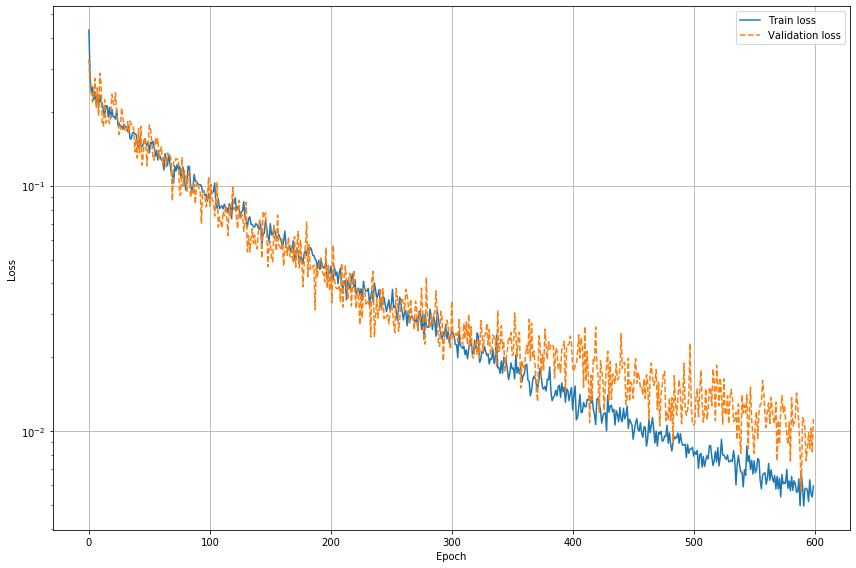

In [16]:
# Plot losses
plt.close('all')
plt.figure(figsize=(12,8))

plt.semilogy(train_loss_epochs, label='Train loss')
plt.semilogy(val_loss_epochs, label='Validation loss', linestyle='dashed')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig(images_path+f"/model_losses_{crop_len}_{min_len}"+"_{}_{}.png".format(params['lr'],params['wd']))
plt.show()

# Text generation

In [17]:
# Set seed
seed = 'When you are alone in the middle of the sea'

In [25]:
# Load embeddings
with open('./data/embeddings', 'rb') as f:
    embeddings = pickle.load(f)
    
# Get list of words
words = [*embeddings.keys()]
# Get vectors as float tensor
vectors = torch.tensor([*embeddings.values()], dtype=torch.float)
    

# Load hyperparameters
with open(res_path + "/" + out_dir, 'rb') as f:
    params = pickle.load(f)
    params = params['params']

# Embedding matrix
X = np.array(list(embeddings.values()))
    
# Set device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Load model
state = torch.load(res_path + "/state_" + out_dir + '.pth', map_location = device)

net = Network(vocab_size = len(embeddings.keys()),
              embedding_dim = 50,
              hidden_units = params['hidden_units'],
              layers_num = params['layers_num'],
              hidden_type = 'LSTM',
              trained_embeddings = vectors,
              dropout_prob = params['dropout_prob']
             )

net.load_state_dict(state)
net.to(device)

ModuleAttributeError: 'Embedding' object has no attribute 'values'

In [19]:
# Initialize WordToVector
w2v = WordToVector(words)

In [23]:
# Evaluation mode
net.eval()

print(seed, end=' ', flush=True)

net_state = None
with torch.no_grad():
    # Generate n words
    for i in range(15):
        # Transform words in the corresponding indices
        seed_encoded = torch.tensor(w2v(seed.lower()))
        # Reshape: batch-like shape
        seed_encoded = torch.reshape(seed_encoded, (1, -1))
        # Move to the selected device
        seed_encoded.to(device)
        # Forward step
        net_out, net_state = net(seed_encoded, net_state)
        # Retrieve the index of the embedding closest to the net output
        closest_index = np.argmin(np.linalg.norm((X - net_out[:, -1, :].to('cpu').numpy()[0]), axis = 1))
        # Retrieve the chosen word text
        closest_word = words[closest_index]
        # Add to the seed sentence
        seed += ' ' + closest_word
        # Print the current result
        print(closest_word, end=' ', flush=True)        

When you are alone in the middle of the sea likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise likewise 